
#  Tunisian Real Estate Data Cleaning Pipeline

This notebook cleans and prepares Tunisian real estate data from multiple sources

## 0) Setup

In [125]:
from __future__ import annotations

import re
import unicodedata
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [126]:
SCRAPED_DATA = r"C:\Users\user\OneDrive\Bureau\Data Mining Projecy\Tunisan-Real-Estate-Price-Prediction-Platform\ML\data\raw\final_scrapped_immobiliers.csv"
KAGGLE_DATA = r"C:\Users\user\OneDrive\Bureau\Data Mining Projecy\Tunisan-Real-Estate-Price-Prediction-Platform\ML\data\raw\tayara.csv"

# Data quality thresholds
IQR_MULTIPLIER = 5.0  # For outlier detection
MAX_BATHROOMS = 15
MAX_ROOMS = 20

print("✓ Configuration loaded")

✓ Configuration loaded


## 1) Utility functions


In [ ]:
def strip_accents(text: str) -> str:
    """Remove accents from text while preserving meaning."""
    text = unicodedata.normalize("NFKD", str(text))
    return "".join(ch for ch in text if not unicodedata.combining(ch))


def normalize_text(text: str) -> str:
    """Comprehensive text normalization."""
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = strip_accents(text).lower()
    text = text.replace("_", " ").replace("-", " ")
    text = re.sub(r"\bs\s*plus\s*", "s+", text)  # Normalize "s plus" -> "s+"
    text = re.sub(r"\s+", " ", text).strip()
    return text

def print_section(title: str, char: str = "=", width: int = 80):
    print("\n" + char * width)
    print(title)
    print(char * width)



def analyze_missing_values(df: pd.DataFrame, name: str = "Dataset"):
    """Comprehensive missing values analysis."""
    print_section(f"MISSING VALUES - {name}" )
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing': missing.values,
        'Percent': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))
        print(f"\n⚠️  Total columns with missing values: {len(missing_df)}")
        print(f"⚠️  Total missing values: {missing.sum():,}")
    else:
        print("✓ No missing values!")
    
    return missing_df

## 2) Data Loading

In [128]:
print_section("📂 LOADING DATA")
df_tayara = pd.read_csv(SCRAPED_DATA)
df_other  = pd.read_csv(KAGGLE_DATA)

print(f"Tayara dataset: {df_tayara.shape[0]:,} rows × {df_tayara.shape[1]} columns")
print(f"Other dataset:  {df_other.shape[0]:,} rows × {df_other.shape[1]} columns")
print(f"Total records:  {df_tayara.shape[0] + df_other.shape[0]:,}")


📂 LOADING DATA
Tayara dataset: 21,873 rows × 10 columns
Other dataset:  9,296 rows × 9 columns
Total records:  31,169


## 3) Data Exploration

In [129]:
print("\n=== TAYARA DATASET ===")
display(df_tayara.head(3))

print("\n=== OTHER DATASET ===")
display(df_other.head(3))


=== TAYARA DATASET ===


,link,title,price,transaction,city,region,description,surface,bathrooms,rooms
0,NaN,NaN,6800.0,rent,Gammarth,La Marsa,Un Penthouse en s3 à Gammarth avec une vue sur...,350.0,1.0,4.0
1,NaN,NaN,NaN,rent,Carthage,Carthage,A louer une villa meublée avec piscine à Carth...,4.0,NaN,3.0
2,NaN,NaN,3800.0,rent,La Marsa,La Marsa,A louer un s2 au rez de chaussée à la Marsa\nC...,3.0,NaN,2.0



=== OTHER DATASET ===


,price,transaction,title,city,region,description,surface,bathrooms,rooms
0,6.000000e+02,rent,à RTIBA pour toute saison : la plus belle plag...,Nabeul,Takelsa,Pour groupes et familles (8 personnes et plus)...,3000,2,3
1,1.020000e+09,sale,une villa àvec piscine à vendre,Ariana,La_Soukra,Cette villa de charme est située dans un quart...,270,2,3
2,4.900000e+05,sale,S+3 avec jardin à chotrana 1,Ariana,Chotrana_1,Cet appartement est situé au rez-de-chaussée d...,141,3,3


In [130]:
print_section("📋 INITIAL DATA ANALYSIS")

print("TAYARA DATASET INFO:")
print("-" * 80)
df_tayara.info()

print("\n\nOTHER DATASET INFO:")
print("-" * 80)
df_other.info()


📋 INITIAL DATA ANALYSIS
TAYARA DATASET INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21873 entries, 0 to 21872
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         4651 non-null   object 
 1   title        4651 non-null   object 
 2   price        19741 non-null  float64
 3   transaction  21117 non-null  object 
 4   city         21873 non-null  object 
 5   region       21873 non-null  object 
 6   description  21845 non-null  object 
 7   surface      20428 non-null  float64
 8   bathrooms    17112 non-null  float64
 9   rooms        19478 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.7+ MB


OTHER DATASET INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9296 entries, 0 to 9295
Data columns (total 9 columns):

In [131]:
analyze_missing_values(df_tayara, "Tayara")
analyze_missing_values(df_other, "Other")


MISSING VALUES - Tayara
     Column  Missing   Percent
       link    17222 78.736342
      title    17222 78.736342
  bathrooms     4761 21.766562
      rooms     2395 10.949573
      price     2132  9.747177
    surface     1445  6.606318
transaction      756  3.456316
description       28  0.128012

⚠️  Total columns with missing values: 8
⚠️  Total missing values: 45,961

MISSING VALUES - Other
     Column  Missing  Percent
      price       39 0.419535
description       15 0.161360

⚠️  Total columns with missing values: 2
⚠️  Total missing values: 54


,Column,Missing,Percent
0,price,39,0.419535
5,description,15,0.161360


In [132]:
print_section("🔍 CHECKING DUPLICATES")

tayara_dupes = df_tayara.duplicated().sum()
other_dupes = df_other.duplicated().sum()

print(f"Tayara duplicates: {tayara_dupes:,} ({tayara_dupes/len(df_tayara)*100:.2f}%)")
print(f"Other duplicates:  {other_dupes:,} ({other_dupes/len(df_other)*100:.2f}%)")


🔍 CHECKING DUPLICATES
Tayara duplicates: 862 (3.94%)
Other duplicates:  753 (8.10%)


## 4) Harmonizing the datasets

In [133]:
print_section("🔄 STANDARDIZING TRANSACTION FIELD")

# Create working copies
df_tayara_clean = df_tayara.copy()
df_other_clean = df_other.copy()

print("Before standardization:")
print(f"  Tayara: {df_tayara_clean['transaction'].unique()}")
print(f"  Other:  {df_other_clean['transaction'].unique()}")

# Mapping
transaction_map = {
    'Location': 'rent', 'Vente': 'sale',
    'location': 'rent', 'vente': 'sale',
    'rent': 'rent', 'sale': 'sale'
}

df_tayara_clean['transaction'] = df_tayara_clean['transaction'].map(transaction_map)
df_other_clean['transaction'] = df_other_clean['transaction'].map(transaction_map)

print("\nAfter standardization:")
print(f"  Tayara: {df_tayara_clean['transaction'].unique()}")
print(f"  Other:  {df_other_clean['transaction'].unique()}")


🔄 STANDARDIZING TRANSACTION FIELD
Before standardization:
  Tayara: ['rent' 'sale' 'Location' 'Vente' nan]
  Other:  ['rent' 'sale']

After standardization:
  Tayara: ['rent' 'sale' nan]
  Other:  ['rent' 'sale']


In [134]:
print_section("🔢 CONVERTING DATA TYPES")

# Convert object columns to numeric in Other dataset
print("Converting surface, bathrooms, rooms to numeric...")
for col in ['surface', 'bathrooms', 'rooms']:
    df_other_clean[col] = pd.to_numeric(df_other_clean[col], errors='coerce')
    print(f"  ✓ {col}: {df_other_clean[col].dtype}")


🔢 CONVERTING DATA TYPES
Converting surface, bathrooms, rooms to numeric...
  ✓ surface: float64
  ✓ bathrooms: float64
  ✓ rooms: float64


In [135]:
print_section("📐 ALIGNING COLUMNS")

# Drop link column from Tayara
if 'link' in df_tayara_clean.columns:
    df_tayara_clean = df_tayara_clean.drop(columns=['link'])
    print("✓ Dropped 'link' column")

# Define column order
desired_cols = ['title', 'price', 'transaction', 'city', 'region',
                'description', 'surface', 'bathrooms', 'rooms']

df_tayara_clean = df_tayara_clean[desired_cols]
df_other_clean = df_other_clean[desired_cols]

print(f"✓ Columns aligned: {desired_cols}")


📐 ALIGNING COLUMNS
✓ Dropped 'link' column
✓ Columns aligned: ['title', 'price', 'transaction', 'city', 'region', 'description', 'surface', 'bathrooms', 'rooms']


## 5) Merging datasets

In [136]:
print_section("🔗 MERGING DATASETS")

print(f"Before merge:")
print(f"  Tayara: {df_tayara_clean.shape[0]:,} rows")
print(f"  Other:  {df_other_clean.shape[0]:,} rows")

df_merged = pd.concat([df_tayara_clean, df_other_clean], ignore_index=True)

print(f"\nAfter merge: {df_merged.shape[0]:,} rows × {df_merged.shape[1]} columns")


🔗 MERGING DATASETS
Before merge:
  Tayara: 21,873 rows
  Other:  9,296 rows

After merge: 31,169 rows × 9 columns


## 6) Imputing Missing values From Description

### Imputing Transaction

In [137]:
# ============================================================
# 3) Transaction: impute ONLY NaN from title+description
#    (outputs: 'rent' or 'sale')
# ============================================================

RENT_PATTERNS = [
    r"\b(a|à)\s*louer\b", r"\blocation\b", r"\blouer\b", r"\bfor rent\b", r"\brent\b",
    r"\bpar mois\b", r"\b/mois\b", r"\bmensuel(le)?\b", r"\bcolocation\b",
    r"\bpar jour\b", r"\b/jour\b", r"\bnuit(ee)?\b", r"\bseasonal\b", r"\bvacances\b",
    r"لل?كراء", r"لل?إيجار", r"ايجار", r"كراء", r"تأجير"
]

SALE_PATTERNS = [
    r"\b(a|à)\s*vendre\b", r"\bvente\b", r"\bvendre\b", r"\bfor sale\b",
    r"\bà\s*c[ée]der\b", r"\bceder\b",
    r"للبيع", r"بيع"
]

rent_re = re.compile("|".join(RENT_PATTERNS), flags=re.IGNORECASE)
sale_re = re.compile("|".join(SALE_PATTERNS), flags=re.IGNORECASE)

def infer_transaction_from_text(title, description):
    text = normalize_text(f"{title} {description}")

    is_rent = bool(rent_re.search(text))
    is_sale = bool(sale_re.search(text))

    # If both match, try strong hints; otherwise ambiguous => NA
    if is_rent and is_sale:
        strong_rent = any(k in text for k in [
            "par mois", "/mois", "mensuel", "location", "a louer", "à louer",
            "للكراء", "للإيجار", "كراء"
        ])
        strong_sale = any(k in text for k in ["a vendre", "à vendre", "vente", "للبيع", "بيع"])

        if strong_rent and not strong_sale:
            return "rent"
        if strong_sale and not strong_rent:
            return "sale"
        return pd.NA

    if is_rent:
        return "rent"
    if is_sale:
        return "sale"
    return pd.NA


def impute_transaction_only_nan(df, trans_col="transaction", title_col="title", desc_col="description"):
    """
    Impute ONLY missing transaction values from title+description.
    Modifies df in-place and also returns df for convenience.
    """
    if trans_col not in df.columns:
        df[trans_col] = pd.NA

    missing = df[trans_col].isna()
    n_missing_before = int(missing.sum())

    if n_missing_before == 0:
        print(f"Missing '{trans_col}' before: 0")
        print(f"Imputed '{trans_col}' from text: 0")
        print("\nTransaction distribution (after):")
        print(df[trans_col].value_counts(dropna=False))
        return df

    pred = df.loc[missing].apply(
        lambda r: infer_transaction_from_text(r.get(title_col, ""), r.get(desc_col, "")),
        axis=1
    )

    n_imputed = int(pred.notna().sum())

    # ✅ assign back into the SAME df (this fixes your error)
    df.loc[missing, trans_col] = pred

    print(f"Missing '{trans_col}' before: {n_missing_before}")
    print(f"Imputed '{trans_col}' from text: {n_imputed}")
    print("\nTransaction distribution (after):")
    print(df[trans_col].value_counts(dropna=False))

    return df


# ======================
# Usage
# ======================
TRANS_COL = "transaction"

df_merged = impute_transaction_only_nan(df_merged)

#  drop remaining NaNs after imputation
before = len(df_merged)
df_merged = df_merged.dropna(subset=['transaction'])
print(f"Dropped {before - len(df_merged):,} rows with NaN {TRANS_COL} after imputation")


Missing 'transaction' before: 756
Imputed 'transaction' from text: 602

Transaction distribution (after):
transaction
rent    16320
sale    14695
<NA>      154
Name: count, dtype: int64
Dropped 154 rows with NaN transaction after imputation


### Imputing surface

In [138]:
# matches: "120 m2", "120m²", "120 m²", "120,5 m2", "120.5m²"
SURFACE_RE = re.compile(
    r"(?<!\d)(\d{1,4}(?:[.,]\d{1,2})?)\s*(?:m2|m²|㎡)\b",
    flags=re.IGNORECASE
)

def extract_surface_m2(text: str):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return None
    t = str(text).lower()

    matches = SURFACE_RE.findall(t)
    if not matches:
        return None

    # convert all matches to floats and pick the largest (often "surface totale")
    vals = []
    for m in matches:
        try:
            vals.append(float(m.replace(",", ".")))
        except Exception:
            pass
    if not vals:
        return None

    surface = max(vals)

    # basic sanity bounds (adjust to your market)
    if surface < 5 or surface > 2000:
        return None

    return surface


def impute_surface_from_text(df, surface_col="surface", title_col="title", desc_col="description", inplace=True):
    s = pd.to_numeric(df[surface_col], errors="coerce")
    missing = s.isna() | (s <= 0)

    text = (
        df[title_col].fillna("").astype(str) + " " +
        df[desc_col].fillna("").astype(str)
    )

    extracted = text.loc[missing].apply(extract_surface_m2)
    n_imputed = int(pd.Series(extracted).notna().sum())

    if inplace:
        df.loc[missing, surface_col] = extracted

    return n_imputed


# -------- usage ----------
n = impute_surface_from_text(df_merged)
print(f"Imputed surface for {n:,} rows from text (m²/m2)")


Imputed surface for 378 rows from text (m²/m2)


### Imputing Rooms

In [139]:
# ============================================================
# 2) Rooms: impute ONLY NaN from title+description
# (NO outlier -> NaN step for now)
# ============================================================

SPLUS_RE    = re.compile(r"\bs\s*(?:\+|plus)?\s*(\d{1,2})\b", flags=re.IGNORECASE)  # s2, s+2, s plus 2
CH_RE       = re.compile(r"\b(\d{1,2})\s*(?:chambres?|ch\b|pieces?|pi[eè]ces?)\b", flags=re.IGNORECASE)
AR_ROOMS_RE = re.compile(r"\b(\d{1,2})\s*(?:غرف|غرفة)\b")
STUDIO_RE   = re.compile(r"\b(studio|ستوديو|ستيديو)\b", flags=re.IGNORECASE)

def infer_rooms_from_text(title, description):
    text = normalize_text(f"{title} {description}")

    # S+N => N
    m = SPLUS_RE.search(text)
    if m:
        return int(m.group(1))

    # N chambres / pieces
    m = CH_RE.search(text)
    if m:
        return int(m.group(1))

    # Arabic
    m = AR_ROOMS_RE.search(text)
    if m:
        return int(m.group(1))

    # studio keyword => 0 (only if nothing else matched)
    if STUDIO_RE.search(text):
        return 0

    return pd.NA


ROOM_COL = "rooms"

# build the missing mask on df_merged
missing_mask = (
    df_merged[ROOM_COL].isna() |
    (df_merged[ROOM_COL].astype(str).str.strip() == "") |
    (df_merged[ROOM_COL].astype(str).str.lower().isin(["nan", "none", "null"]))
)

pred_rooms = df_merged.loc[missing_mask].apply(
    lambda r: infer_rooms_from_text(r.get("title", ""), r.get("description", "")),
    axis=1
)

n_missing_before = int(missing_mask.sum())
n_imputed = int(pred_rooms.notna().sum())

# assign into df_merged using df_merged mask
df_merged.loc[missing_mask, ROOM_COL] = pred_rooms

# normalize dtype (no outlier cleaning here)
df_merged[ROOM_COL] = pd.to_numeric(df_merged[ROOM_COL], errors="coerce").astype("Int64")

print(f"Missing '{ROOM_COL}' before: {n_missing_before}")
print(f"Imputed from title/description: {n_imputed}")
print("\nRooms distribution (final):")
print(df_merged[ROOM_COL].value_counts(dropna=False).sort_index())


Missing 'rooms' before: 2272
Imputed from title/description: 880

Rooms distribution (final):
rooms
-5             2
-4             1
-3             3
-2            15
-1            42
            ... 
310000         3
370000         1
1111111        1
69804588       1
<NA>        1392
Name: count, Length: 65, dtype: Int64


## 6) Data Cleaning

### Removing Duplicates

In [140]:
print_section("🗑️ REMOVING DUPLICATES")

initial_rows = len(df_merged)
key_cols = ['title', 'price', 'transaction', 'region',  # Removed city
            'surface', 'bathrooms', 'rooms']

df_merged = df_merged.drop_duplicates(subset=key_cols, keep='first')

removed = initial_rows - len(df_merged)
print(f"Removed {removed:,} duplicates ({removed/initial_rows*100:.2f}%)")
print(f"Remaining: {len(df_merged):,} rows")


🗑️ REMOVING DUPLICATES
Removed 3,436 duplicates (11.08%)
Remaining: 27,579 rows


In [141]:
df_clean = df_merged.copy()
print(f"\n✓ Created working copy: {df_clean.shape[0]:,} rows")



✓ Created working copy: 27,579 rows


### Cleaning Price Column

#### Deleting Rent by Night prices

In [142]:
import numpy as np
import pandas as pd

# Nettoyage basique
df_clean["transaction"] = df_clean["transaction"].astype(str).str.strip().str.lower()

# ✅ Mots-clés FR/EN + AR qui indiquent un prix "par nuit"
night_keywords = r"(" \
                 r"par\s*nuit(ée)?|/nuit(ée)?|\bnuit(ée)?\b|night|per\s*night|/night|nightly" \
                 r"|" \
                 r"ل(?:ل)?(?:ليلة|ليله)|بالليلة|بالليله|لليلة|لليله|في\s*الليلة|في\s*الليله|سعر\s*الليلة|سعر\s*الليله" \
                 r")"

# Colonnes texte
text_cols = df_clean.select_dtypes(include=["object", "string"]).columns

rent_mask = df_clean["transaction"].eq("rent")

# Chercher dans toutes les colonnes texte
contains_night = pd.Series(False, index=df_clean.index)
for c in text_cols:
    contains_night |= df_clean[c].astype(str).str.contains(night_keywords, case=False, na=False, regex=True)

mask = rent_mask & contains_night

# Mettre price à NaN
df_clean.loc[mask, "price"] = np.nan

print("Nombre de lignes mises à NaN (rent + prix par nuit):", int(mask.sum()))

Nombre de lignes mises à NaN (rent + prix par nuit): 946


#### Price Outliers function

In [143]:
def detect_price_outliers_per_transaction(
    df: pd.DataFrame,
    price_col: str = "price",
    transaction_col: str = "transaction",
    method: str = "market_plus_logiqr",  # "market_only", "market_plus_logiqr", "percentile_wide"
    market_bounds: dict | None = None,
    log_iqr_k: float = 2.75,            # larger = keeps more high-end (2.5–3.5 typical)
    wide_low_q: float = 0.01,           # used by percentile_wide
    wide_high_q: float = 0.995,         # used by percentile_wide
    inplace: bool = True,
):
    """
    Robust real-estate price cleaning per transaction type.

    Methods:
    - "market_only": remove only outside hard market bounds.
    - "market_plus_logiqr": apply hard bounds, then log-IQR outliers within bounds
                            (best default: keeps luxury, removes obvious errors).
    - "percentile_wide": apply hard bounds + wide percentiles (keeps most highs).

    Returns: (total_removed, bounds_info)
    bounds_info contains thresholds and counts per transaction type.
    """

    if market_bounds is None:
        market_bounds = {
            "rent": {"min": 300, "max": 20000},
            "sale": {"min": 40000, "max": 5_000_000},
        }

    s = pd.to_numeric(df[price_col], errors="coerce")
    outlier_mask_total = pd.Series(False, index=df.index)
    bounds_info = {}

    for trans_type, idx in df.groupby(transaction_col).groups.items():
        sg_all = s.loc[idx]
        sg = sg_all.dropna()

        hard_min = market_bounds.get(trans_type, {}).get("min", 0)
        hard_max = market_bounds.get(trans_type, {}).get("max", float("inf"))

        if sg.empty:
            bounds_info[trans_type] = {
                "lower": None, "upper": None, "method": "empty",
                "removed": 0, "total": 0, "pct_removed": 0.0,
                "hard_min": hard_min, "hard_max": hard_max,
            }
            continue

        # --- 1) Hard market bounds always apply (remove only impossible values)
        mask_hard = (sg_all < hard_min) | (sg_all > hard_max)

        # Work on "in-bounds" values for statistical detection
        in_bounds = sg_all[~mask_hard].dropna()

        if method == "market_only":
            mask_final = mask_hard
            lower, upper = hard_min, hard_max

        elif method == "market_plus_logiqr":
            lower, upper = hard_min, hard_max

            if in_bounds.empty:
                mask_final = mask_hard
            else:
                # Log-IQR on in-bounds values (keeps luxury if log_iqr_k is generous)
                x = np.log1p(in_bounds)
                q1 = x.quantile(0.25)
                q3 = x.quantile(0.75)
                iqr = q3 - q1

                if iqr == 0 or not np.isfinite(iqr):
                    # No variance => only hard bounds
                    mask_final = mask_hard
                else:
                    lo_x = q1 - log_iqr_k * iqr
                    hi_x = q3 + log_iqr_k * iqr
                    soft_lower = max(np.expm1(lo_x), hard_min)
                    soft_upper = min(np.expm1(hi_x), hard_max)

                    mask_soft = (sg_all < soft_lower) | (sg_all > soft_upper)
                    mask_final = mask_hard | mask_soft

                    lower, upper = soft_lower, soft_upper

        elif method == "percentile_wide":
            # Wide percentiles + hard bounds (still chops extremes, but far less than p95)
            p_lo = in_bounds.quantile(wide_low_q) if not in_bounds.empty else hard_min
            p_hi = in_bounds.quantile(wide_high_q) if not in_bounds.empty else hard_max
            lower = max(p_lo, hard_min)
            upper = min(p_hi, hard_max)
            mask_soft = (sg_all < lower) | (sg_all > upper)
            mask_final = mask_hard | mask_soft

        else:
            raise ValueError(f"Unknown method: {method}")

        outlier_mask_total.loc[idx] = mask_final

        total_non_null = int(sg.notna().sum())
        removed = int(mask_final.sum())
        bounds_info[trans_type] = {
            "lower": float(lower) if lower is not None else None,
            "upper": float(upper) if upper is not None else None,
            "hard_min": float(hard_min),
            "hard_max": float(hard_max),
            "method": method,
            "removed": removed,
            "total": total_non_null,
            "pct_removed": (removed / total_non_null * 100) if total_non_null else 0.0,
            "hard_removed": int(mask_hard.sum()),
        }

    if inplace:
        df.loc[outlier_mask_total, price_col] = np.nan

    return int(outlier_mask_total.sum()), bounds_info



#### Removing Price Outlier Values

In [144]:
def print_section(title: str):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

print_section("💰 CLEANING PRICE COLUMN")

print(f"Price range before: {df_clean['price'].min():,.0f} - {df_clean['price'].max():,.0f} TND")

# Fix invalid prices (≤0)
invalid_prices = ((df_clean["price"] <= 0) | (df_clean["price"].isna())).sum()
print(f"Found {invalid_prices:,} invalid prices (≤0 or NaN)")
df_clean.loc[df_clean["price"] <= 0, "price"] = np.nan

# Tunisian market-specific bounds
TRANSACTION_BOUNDS = {
    "rent": {"min": 300, "max": 20000},       # Monthly rent in TND
    "sale": {"min": 40000, "max": 5000000},   # Sale price in TND
}

# Best default: keeps high-end, removes nonsense (hard bounds + log-IQR)
outliers_count, bounds_info = detect_price_outliers_per_transaction(
    df_clean,
    price_col="price",
    transaction_col="transaction",
    method="market_plus_logiqr",
    market_bounds=TRANSACTION_BOUNDS,
    log_iqr_k=2.75,   # increase to 3.25 if still removing too many luxury listings
    inplace=True
)

print(f"\nMarked {outliers_count:,} outliers as NaN (hard market bounds + log-IQR)")
print("Market bounds applied:")
for t, b in TRANSACTION_BOUNDS.items():
    print(f"  - {t.upper()}: {b['min']:,} - {b['max']:,} TND")

print("\nResults per transaction type:")
for t, info in bounds_info.items():
    if info["lower"] is not None:
        print(f"  {t.upper()}:")
        print(f"    Final valid range: {info['lower']:,.0f} - {info['upper']:,.0f} TND")
        print(f"    Removed: {info['removed']:,} ({info['pct_removed']:.1f}% of {info['total']})")
        print(f"    Outside hard bounds removed: {info['hard_removed']:,}")
    else:
        print(f"  {t.upper()}: {info['method']}")

print(f"\nPrice range after: {df_clean['price'].min():,.0f} - {df_clean['price'].max():,.0f} TND")
print(f"Remaining price records: {df_clean['price'].notna().sum():,}")


💰 CLEANING PRICE COLUMN
Price range before: -3 - 3,324,000,000 TND
Found 3,971 invalid prices (≤0 or NaN)

Marked 2,307 outliers as NaN (hard market bounds + log-IQR)
Market bounds applied:
  - RENT: 300 - 20,000 TND
  - SALE: 40,000 - 5,000,000 TND

Results per transaction type:
  RENT:
    Final valid range: 300 - 20,000 TND
    Removed: 1,353 (11.2% of 12079)
    Outside hard bounds removed: 1,353
  SALE:
    Final valid range: 40,000 - 5,000,000 TND
    Removed: 954 (8.3% of 11529)
    Outside hard bounds removed: 954

Price range after: 300 - 5,000,000 TND
Remaining price records: 21,301


#### Removing Price Values with Outlier Price/m2 Value

In [145]:
# 0) Ensure numeric + valid
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")
df_clean["surface"] = pd.to_numeric(df_clean["surface"], errors="coerce")

df_clean.loc[df_clean["price"] <= 0, "price"] = np.nan
df_clean.loc[df_clean["surface"] <= 0, "surface"] = np.nan

# 1) Create price_per_m2 only for valid price & surface
df_clean["price_per_m2"] = df_clean["price"] / df_clean["surface"]

# 2) Market-based bounds for price/m² per transaction type
PPM2_BOUNDS = {
    'rent': {'min': 10, 'max': 150},           # TND/m² per month (realistic for Tunisia)
    'sale': {'min': 1000, 'max': 25000}       # TND/m² for property sales
}

# Detect price/m² outliers using percentile method
ppm2_removed, ppm2_info = detect_price_outliers_per_transaction(
    df_clean,
    price_col="price_per_m2",
    transaction_col="transaction",
    method="percentile_wide",
    market_bounds=PPM2_BOUNDS,
    inplace=False  # Don't mark yet, we'll handle specially
)

# For price/m² outliers, remove the entire price record (not just price_per_m2)
s_ppm2 = pd.to_numeric(df_clean['price_per_m2'], errors="coerce")
for trans_type, idx in df_clean.groupby('transaction').groups.items():
    sg_ppm2 = s_ppm2.loc[idx].dropna()
    
    if sg_ppm2.empty or trans_type not in ppm2_info or ppm2_info[trans_type]['lower'] is None:
        continue
    
    lower = ppm2_info[trans_type]['lower']
    upper = ppm2_info[trans_type]['upper']
    
    # Mark outliers by setting price to NaN
    outlier_mask = (df_clean.index.isin(idx)) & ((s_ppm2 < lower) | (s_ppm2 > upper))
    df_clean.loc[outlier_mask, 'price'] = np.nan

print("\nPrice/m² Outlier Detection Results:")
print(f"Market bounds applied:")
for trans_type, bounds_val in PPM2_BOUNDS.items():
    print(f"  - {trans_type.upper()}: {bounds_val['min']} - {bounds_val['max']} TND/m²")

print(f"\nPer transaction type:")
for trans_type, info in ppm2_info.items():
    if info['lower'] is not None:
        print(f"  {trans_type.upper()}:")
        print(f"    Valid range: {info['lower']:.1f} - {info['upper']:.0f} TND/m²")
        print(f"    Outliers: {info['removed']} ({info['pct_removed']:.1f}% of {info['total']})")

print(f"Total outliers removed: {ppm2_removed}")


Price/m² Outlier Detection Results:
Market bounds applied:
  - RENT: 10 - 150 TND/m²
  - SALE: 1000 - 25000 TND/m²

Per transaction type:
  RENT:
    Valid range: 10.0 - 85 TND/m²
    Outliers: 3300 (31.4% of 10512)
  SALE:
    Valid range: 1054.7 - 10579 TND/m²
    Outliers: 1040 (10.0% of 10443)
Total outliers removed: 4340


#### Removing very Low Prices (Transaction-Specific Thresholds)

In [146]:
import numpy as np
import pandas as pd

# ensure price is numeric
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# Transaction-specific minimum price thresholds
min_price_thresholds = {
    'rent': 200,   # Minimum reasonable monthly rent in TND
    'sale': 50000   # Minimum reasonable sale price in TND
}

print("\nApplying transaction-specific minimum price thresholds:")
total_removed = 0

for transaction_type, min_threshold in min_price_thresholds.items():
    mask = (df_clean['transaction'] == transaction_type) & (df_clean['price'] < min_threshold)
    count = mask.sum()
    df_clean.loc[mask, 'price'] = np.nan
    print(f"  {transaction_type}: removed {count:,} prices < {min_threshold:,} TND")
    total_removed += count

print(f"\nTotal prices set to NaN: {total_removed:,}")


Applying transaction-specific minimum price thresholds:
  rent: removed 0 prices < 200 TND
  sale: removed 9 prices < 50,000 TND

Total prices set to NaN: 9


### Cleaning Surface Columns

#### Surface Outlier function

In [147]:
def mark_surface_outliers_as_nan(
    df,
    column="surface",
    multiplier=2.5,
    min_value=1.0,
    max_value=None,
    method="log_iqr",          # "iqr" or "log_iqr"
    inplace=True,
):
    """
    Marks outliers in a surface column as NaN using IQR (or log-IQR for heavy right-skew).
    Returns: (outliers_count, lower_bound, upper_bound)
    """
    s = pd.to_numeric(df[column], errors="coerce")

    # Domain invalids
    invalid_mask = s.isna() | (s < min_value)
    if max_value is not None:
        invalid_mask |= (s > max_value)

    clean = s[~invalid_mask].dropna()
    if clean.empty:
        if inplace:
            df.loc[invalid_mask, column] = np.nan
        return int(invalid_mask.sum()), None, None

    if method == "log_iqr":
        x = np.log1p(clean)
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr == 0:
            if inplace:
                df.loc[invalid_mask, column] = np.nan
            return int(invalid_mask.sum()), None, None

        lo_x = q1 - multiplier * iqr
        hi_x = q3 + multiplier * iqr
        lower = float(np.expm1(lo_x))
        upper = float(np.expm1(hi_x))
    else:  # "iqr"
        q1, q3 = clean.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr == 0:
            if inplace:
                df.loc[invalid_mask, column] = np.nan
            return int(invalid_mask.sum()), None, None

        lower = float(q1 - multiplier * iqr)
        upper = float(q3 + multiplier * iqr)

    # Apply optional bounds
    lower = max(min_value, lower)
    if max_value is not None:
        upper = min(upper, max_value)

    outlier_mask = invalid_mask | (s < lower) | (s > upper)
    outliers_count = int(outlier_mask.sum())

    if inplace:
        df.loc[outlier_mask, column] = np.nan

    return outliers_count, lower, upper


#### Removing surface outlier values

In [148]:
print_section("📏 CLEANING SURFACE COLUMN")

print(f"Surface range before: {df_clean['surface'].min():.0f} - {df_clean['surface'].max():.0f}")

# Set invalid to NaN
df_clean.loc[df_clean['surface'] <= 0, 'surface'] = np.nan

# Mark outliers
outliers_count, lower, upper = mark_surface_outliers_as_nan(df_clean, 'surface')

print(f"Marked {outliers_count:,} outliers as NaN")
print(f"Valid range: {lower:.0f} - {upper:.0f}")
print(f"Surface range after: {df_clean['surface'].min():.0f} - {df_clean['surface'].max():.0f}")


📏 CLEANING SURFACE COLUMN
Surface range before: 0 - 11111111
Marked 1,908 outliers as NaN
Valid range: 5 - 3501
Surface range after: 6 - 3500


### Cleaning Bathrooms Column

In [149]:
print_section("🚿 CLEANING BATHROOMS COLUMN")

# Set invalid to NaN
invalid_bathrooms = ((df_clean['bathrooms'] <= 0) | df_clean['bathrooms'].isna()).sum()
df_clean.loc[df_clean['bathrooms'] <= 0, 'bathrooms'] = np.nan
print(f"Set {invalid_bathrooms:,} invalid values to NaN")

# Mark outliers
outliers_bath = (df_clean['bathrooms'] >= MAX_BATHROOMS).sum()
df_clean.loc[df_clean['bathrooms'] >= MAX_BATHROOMS, 'bathrooms'] = np.nan
print(f"Marked {outliers_bath:,} outliers as NaN (≥{MAX_BATHROOMS})")

print(f"Bathrooms range: {df_clean['bathrooms'].min():.0f} - {df_clean['bathrooms'].max():.0f}")


🚿 CLEANING BATHROOMS COLUMN
Set 4,239 invalid values to NaN
Marked 62 outliers as NaN (≥15)
Bathrooms range: 1 - 14


### Cleaning Rooms Column

In [150]:
print_section("🛏️ CLEANING ROOMS COLUMN")

# Set invalid to NaN
invalid_rooms = ((df_clean['rooms'] <= 0) | df_clean['rooms'].isna()).sum()
df_clean.loc[df_clean['rooms'] <= 0, 'rooms'] = np.nan
print(f"Set {invalid_rooms:,} invalid values to NaN")

# Mark outliers
outliers_rooms = (df_clean['rooms'] >= MAX_ROOMS).sum()
df_clean.loc[df_clean['rooms'] >= MAX_ROOMS, 'rooms'] = np.nan
print(f"Marked {outliers_rooms:,} outliers as NaN (≥{MAX_ROOMS})")

print(f"Rooms range: {df_clean['rooms'].min():.0f} - {df_clean['rooms'].max():.0f}")


🛏️ CLEANING ROOMS COLUMN
Set 1,527 invalid values to NaN
Marked 68 outliers as NaN (≥20)
Rooms range: 1 - 19


## 7) Features extraction 

In [151]:
import pandas as pd
import re

def infer_property_type(title, description, rooms=None):
    text = normalize_text(f"{title} {description}")

    # normalize rooms safely
    if rooms is pd.NA or pd.isna(rooms) or rooms is None:
        rooms_val = None
    else:
        try:
            rooms_val = int(float(rooms))
        except Exception:
            rooms_val = None

    # allow studio detection ONLY if rooms unknown or == 0
    allow_studio = (rooms_val is None) or (rooms_val == 0) or (rooms_val == 1)

    is_studio = allow_studio and bool(re.search(r"\bs\s*\+?\s*0\b", text))
    has_s     = bool(re.search(r"\bs\s*\+?\s*\d+\b", text))

    # --- Residential ---
    if (allow_studio and any(k in text for k in ["studio", "ستوديو", "ستيديو"])) or is_studio:
        return "Studio"

    elif "triplex" in text:
        if any(k in text for k in ["villa triplex", "independant", "indépendant", "entree independante", "entrée indépendante"]):
            return "Villa"
        return "Appartement"

    elif "duplex" in text:
        if any(k in text for k in [
            "villa duplex",
            "villa triplex",
            "entree independante", "entrée indépendante",
            "independant", "indépendant"
        ]):
            return "Villa"
        return "Appartement"

    elif any(k in text for k in ["villa", "فيلا"]):
        return "Villa"

    elif any(k in text for k in ["appartement", "appart", "شقة", "برطمان"]):
        return "Appartement"

    elif any(k in text for k in ["maison", "منزل", "دار"]):
        return "Maison"

    elif any(k in text for k in ["terrain", "أرض", "ارض"]):
        return "Terrain"

    # --- Pro / commercial ---
    elif ("fond de commerce" in text) or ("fond" in text and "commerce" in text) or any(k in text for k in ["محل", "تجاري"]):
        return "Fond de commerce"

    if "bureau" in text:
        return "Bureau"

    elif any(k in text for k in ["local", "commercial", "commerce", "magasin", "showroom", "cafe", "salon de the"]):
        return "Local Commercial"

    if "immeuble" in text:
        return "Immeuble"

    elif any(k in text for k in ["depot", "dépôt", "entrepot", "entrepôt", "دبو"]):
        return "Dépôt"

    # --- Fallback S+N ---
    elif has_s:
        return "Appartement"

    return "Other"


df_clean["property_type"] = df_clean.apply(
    lambda r: infer_property_type(r.get("title", ""), r.get("description", ""), r.get("rooms", None)),
    axis=1
)


In [152]:
# Counts per property type
counts = df_clean["property_type"].value_counts(dropna=False)
print(counts)

# Optional: pretty table with percentages
summary = (
    df_clean["property_type"]
    .value_counts(dropna=False)
    .rename_axis("property_type")
    .reset_index(name="count")
)
summary["pct"] = (summary["count"] / len(df_clean) * 100).round(2)
print(summary)


property_type
Appartement         14689
Villa                6677
Maison               1740
Terrain              1077
Bureau               1010
Other                 874
Studio                592
Local Commercial      437
Fond de commerce      203
Immeuble              193
Dépôt                  87
Name: count, dtype: int64
       property_type  count    pct
0        Appartement  14689  53.26
1              Villa   6677  24.21
2             Maison   1740   6.31
3            Terrain   1077   3.91
4             Bureau   1010   3.66
5              Other    874   3.17
6             Studio    592   2.15
7   Local Commercial    437   1.58
8   Fond de commerce    203   0.74
9           Immeuble    193   0.70
10             Dépôt     87   0.32


In [153]:
df_clean["property_type"] = df_clean.apply(
    lambda r: infer_property_type(r.get("title", ""), r.get("description", ""), r.get("rooms", None)),
    axis=1
)


In [154]:
to_drop = [
    "Terrain",
    "Bureau",
    "Local Commercial",
    "Other",
    "Fond de commerce",
    "Dépôt",
    "Immeuble",
]

before = len(df_clean)

df_clean = df_clean[~df_clean["property_type"].isin(to_drop)]

print(f"Dropped {before - len(df_clean):,} rows")

Dropped 3,881 rows


In [155]:

# Extract amenity features from title and description
def extract_amenities(title, description):
    """
    Extract binary features (amenities) from title and description.
    Returns a dict with True/False for each amenity.
    """
    text = normalize_text(f"{title} {description}")
    
    amenities = {
        'has_piscine': bool(re.search(r"\b(piscine|pisci|pool|swimming)\b", text)),
        'has_garage': bool(re.search(r"\b(garage|parking|stationnement|car\s*park)\b", text)),
        'has_jardin': bool(re.search(r"\b(jardin|garden|jardin\s*privé|private\s*garden|حديقة|جنينة)\b", text)),
        'has_terrasse': bool(re.search(r"\b(terrasse|terrace|balcon|balcony|شرفة|صالون)\b", text)),
        'has_ascenseur': bool(re.search(r"\b(ascenseur|ascenseur\s*moderne|elevator|lift|مصعد)\b", text)),
        'is_meuble': bool(re.search(r"\b(meuble|furnished|meublé|ameublé|furnished\s*apartment|شقة\s*مفروشة|مفروش)\b", text)),
        'has_chauffage': bool(re.search(r"\b(chauffage|chauffage\s*central|central\s*heating|heating|radiateur|radiateurs|تدفئة|تسخين)\b", text)),
        'has_climatisation': bool(re.search(r"\b(climatisation|climatisé|climatisée|air\s*conditioning|air\s*conditioned|clim|ac|تكييف|مكيف)\b", text)),
    }
    
    return amenities


# Apply to dataframe
amenity_columns = ['has_piscine', 'has_garage', 'has_jardin', 'has_terrasse', 'has_ascenseur', 'is_meuble', 'has_chauffage', 'has_climatisation']

for col in amenity_columns:
    df_clean[col] = False

# Extract amenities row by row
def extract_amenities_to_row(row):
    result = extract_amenities(
        row.get('title', ''),
        row.get('description', '')
    )
    return pd.Series(result)


# Apply to all rows
amenities_df = df_clean.apply(
    lambda r: extract_amenities_to_row(r),
    axis=1
)

# Assign back to df_clean
for col in amenity_columns:
    df_clean[col] = amenities_df[col]

# Print summary
print_section("🏠 EXTRACTED AMENITIES FROM DESCRIPTION")
print("Amenity Distribution:")
for col in amenity_columns:
    count = df_clean[col].sum()
    pct = (count / len(df_clean)) * 100
    print(f"  {col:20s}: {count:,} ({pct:.2f}%)")



🏠 EXTRACTED AMENITIES FROM DESCRIPTION
Amenity Distribution:
  has_piscine         : 4,063 (17.14%)
  has_garage          : 11,936 (50.37%)
  has_jardin          : 7,688 (32.44%)
  has_terrasse        : 13,666 (57.67%)
  has_ascenseur       : 5,274 (22.26%)
  is_meuble           : 4,779 (20.17%)
  has_chauffage       : 11,253 (47.49%)
  has_climatisation   : 9,933 (41.91%)


## 8) Imputing values Based on group mean

### Imputing Rooms/ Bathrooms

In [156]:
def impute_rooms_bathrooms_group_mean(
    df,
    target_col,
    property_col="property_type",
    transaction_col="transaction",
    region_col="region",
    surface_col="surface",
    price_col="price",
):
    df = df.copy()

    # numeric
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce")
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")

    # ✅ IMPORTANT: force target to float during imputation (avoid Int64 fillna error)
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype(float)

    surface_bins = [0, 20, 35, 50, 70, 90, 120, 160, 220, 300, 450, 700, 1200, 2200]
    rent_price_bins = [0, 300, 600, 900, 1200, 1600, 2200, 3000, 4000, 6000, 9000, 16000]
    sale_price_bins = [0, 60_000, 100_000, 150_000, 220_000, 300_000, 450_000, 650_000,
                       900_000, 1_300_000, 1_900_000, 2_700_000, 3_600_000]

    df["_surface_bin"] = pd.cut(df[surface_col], bins=surface_bins, include_lowest=True)

    price_bin = pd.Series(pd.NA, index=df.index, dtype="object")
    rent_mask = df[transaction_col].astype(str).str.lower().eq("rent")
    sale_mask = df[transaction_col].astype(str).str.lower().eq("sale")
    price_bin.loc[rent_mask] = pd.cut(df.loc[rent_mask, price_col], bins=rent_price_bins, include_lowest=True).astype("object")
    price_bin.loc[sale_mask] = pd.cut(df.loc[sale_mask, price_col], bins=sale_price_bins, include_lowest=True).astype("object")
    df["_price_bin"] = price_bin

    # strict -> relaxed fallbacks (same as before)
    missing = df[target_col].isna()
    keys1 = [property_col, transaction_col, region_col, "_surface_bin", "_price_bin"]
    m1 = df.groupby(keys1, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m1.loc[missing])

    missing = df[target_col].isna()
    keys2 = [property_col, transaction_col, region_col, "_surface_bin"]
    m2 = df.groupby(keys2, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m2.loc[missing])

    missing = df[target_col].isna()
    keys3 = [property_col, transaction_col, region_col]
    m3 = df.groupby(keys3, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m3.loc[missing])

    missing = df[target_col].isna()
    m4 = df.groupby([property_col], dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m4.loc[missing])

    missing = df[target_col].isna()
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(df[target_col].mean())

    # ✅ NOW convert to Int64 safely
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
    df.loc[~np.isfinite(df[target_col]), target_col] = pd.NA
    df[target_col] = df[target_col].round().astype("Int64")
    df.loc[df[target_col] < 0, target_col] = pd.NA

    df.drop(columns=["_surface_bin", "_price_bin"], inplace=True)
    return df


# ------- usage -------
df_clean = impute_rooms_bathrooms_group_mean(df_clean, "rooms", region_col="region")
df_clean = impute_rooms_bathrooms_group_mean(df_clean, "bathrooms", region_col="region")

print("Missing rooms after:", df_clean["rooms"].isna().sum())
print("Missing bathrooms after:", df_clean["bathrooms"].isna().sum())


Missing rooms after: 0
Missing bathrooms after: 0


### Imputing Surface

In [157]:
def impute_surface_group_mean(
    df,
    surface_col="surface",
    price_col="price",
    transaction_col="transaction",
    property_col="property_type",
    region_col="region",
    bathrooms_col="bathrooms",
    rooms_col="rooms",
):
    df = df.copy()

    # numeric
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce").astype(float)
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[bathrooms_col] = pd.to_numeric(df[bathrooms_col], errors="coerce")
    df[rooms_col] = pd.to_numeric(df[rooms_col], errors="coerce")

    # price bins (rent vs sale) based on your ranges
    rent_price_bins = [0, 300, 600, 900, 1200, 1600, 2200, 3000, 4000, 6000, 9000, 16000]
    sale_price_bins = [0, 60_000, 100_000, 150_000, 220_000, 300_000, 450_000, 650_000,
                       900_000, 1_300_000, 1_900_000, 2_700_000, 3_600_000]

    price_bin = pd.Series(pd.NA, index=df.index, dtype="object")
    rent_mask = df[transaction_col].astype(str).str.lower().eq("rent")
    sale_mask = df[transaction_col].astype(str).str.lower().eq("sale")

    price_bin.loc[rent_mask] = pd.cut(df.loc[rent_mask, price_col], bins=rent_price_bins, include_lowest=True).astype("object")
    price_bin.loc[sale_mask] = pd.cut(df.loc[sale_mask, price_col], bins=sale_price_bins, include_lowest=True).astype("object")

    df["_price_bin"] = price_bin

    missing = df[surface_col].isna() | (df[surface_col] <= 0)

    # Level 1: strict (all requested features)
    keys1 = [property_col, transaction_col, region_col, bathrooms_col, rooms_col, "_price_bin"]
    m1 = df.groupby(keys1, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m1.loc[missing])

    # Level 2: drop bathrooms/rooms (still tight with region + prop + trans + price)
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys2 = [property_col, transaction_col, region_col, "_price_bin"]
    m2 = df.groupby(keys2, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m2.loc[missing])

    # Level 3: property + transaction + region
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys3 = [property_col, transaction_col, region_col]
    m3 = df.groupby(keys3, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m3.loc[missing])

    # Level 4: property + transaction
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys4 = [property_col, transaction_col]
    m4 = df.groupby(keys4, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m4.loc[missing])

    # Level 5: global
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(df[surface_col].mean())

    # cleanup + optional rounding (surface often integer-ish; keep 1 decimal if you prefer)
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce")
    df.loc[~np.isfinite(df[surface_col]), surface_col] = pd.NA

    df.drop(columns=["_price_bin"], inplace=True)
    return df


# ------- usage -------
df_clean = impute_surface_group_mean(df_clean)

print("Missing surface after:", (df_clean["surface"].isna() | (df_clean["surface"] <= 0)).sum())

Missing surface after: 0


## 9) Standardize region names

In [158]:
print_section("📍 STANDARDIZING REGION NAMES")
region_map = {
    "l aouina": "L'Aouina", "el aouina": "L'Aouina",
    "klibia": "Kélibia", "kelibia": "Kélibia",
    "cite ennasr 2": "Cité Ennasr 2",
    "zaghouen": "Zaghouan",
    "rades": "Radès", "rads": "Radès",
    "megrine": "Mégrine", "mgrine": "Mégrine",
    "mdina": "Médina",
    "sejoumi": "Séjoumi", "sjoumi": "Séjoumi",
    "hrairia": "Hraïria", "hraria": "Hraïria",
}

print(f"Unique regions before: {df_clean['region'].nunique()}")

# Normalize and map
df_clean['region_norm'] = df_clean['region'].apply(
    lambda x: normalize_text(str(x)) if pd.notna(x) else pd.NA
)
df_clean['region'] = df_clean['region_norm'].map(region_map).fillna(
    df_clean['region_norm'].apply(lambda s: s.title() if pd.notna(s) else pd.NA)
)
df_clean = df_clean.drop(columns=['region_norm'])

print(f"Unique regions after: {df_clean['region'].nunique()}")

print("\nTop 10 regions:")
print(df_clean['region'].value_counts().head(10))


📍 STANDARDIZING REGION NAMES
Unique regions before: 480
Unique regions after: 346

Top 10 regions:
region
La Marsa         4117
Hammamet         1547
La Soukra        1534
Le Kram          1208
Ariana Ville      781
L'Aouina          685
Tunis             534
Kélibia           513
Hammam Sousse     498
Carthage          471
Name: count, dtype: int64


## 10) Optimizing data types

In [159]:
print_section("⚡ OPTIMIZING DATA TYPES")

memory_before = df_clean.memory_usage(deep=True).sum() / 1024**2
print(f"Memory before: {memory_before:.2f} MB")

# Convert to category
for col in df_clean.select_dtypes(include=['object']).columns:
    if col not in ['description', 'title']:
        unique_ratio = df_clean[col].nunique() / len(df_clean)
        if unique_ratio < 0.5:
            df_clean[col] = df_clean[col].astype('category')
            print(f"  ✓ {col}: → category ({df_clean[col].nunique()} unique)")

memory_after = df_clean.memory_usage(deep=True).sum() / 1024**2
reduction = (memory_before - memory_after) / memory_before * 100

print(f"\nMemory after: {memory_after:.2f} MB ({reduction:.1f}% reduction)")


⚡ OPTIMIZING DATA TYPES
Memory before: 21.92 MB
  ✓ transaction: → category (2 unique)
  ✓ city: → category (489 unique)
  ✓ region: → category (346 unique)
  ✓ property_type: → category (4 unique)

Memory after: 16.92 MB (22.8% reduction)


In [160]:
df_clean = df_clean.drop(columns=['title', 'description', 'price_per_m2'])

In [161]:
print_section("📊 FINAL DATASET SUMMARY")

print(f"Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns\n")

print("Columns:")
for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    nulls = df_clean[col].isna().sum()
    null_pct = (nulls / len(df_clean)) * 100
    print(f"  {i:2d}. {col:20s} | {str(dtype):15s} | {nulls:,} nulls ({null_pct:.1f}%)")

print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print("\nProperty Type Distribution:")
print(df_clean['property_type'].value_counts())

print("\nTransaction Distribution:")
print(df_clean['transaction'].value_counts(dropna=False))

print("\nTop 10 Cities:")
print(df_clean['city'].value_counts().head(10))

analyze_missing_values(df_clean, "Final Dataset")


📊 FINAL DATASET SUMMARY
Shape: 23,698 rows × 16 columns

Columns:
   1. price                | float64         | 8,524 nulls (36.0%)
   2. transaction          | category        | 0 nulls (0.0%)
   3. city                 | category        | 0 nulls (0.0%)
   4. region               | category        | 0 nulls (0.0%)
   5. surface              | float64         | 0 nulls (0.0%)
   6. bathrooms            | Int64           | 0 nulls (0.0%)
   7. rooms                | Int64           | 0 nulls (0.0%)
   8. property_type        | category        | 0 nulls (0.0%)
   9. has_piscine          | bool            | 0 nulls (0.0%)
  10. has_garage           | bool            | 0 nulls (0.0%)
  11. has_jardin           | bool            | 0 nulls (0.0%)
  12. has_terrasse         | bool            | 0 nulls (0.0%)
  13. has_ascenseur        | bool            | 0 nulls (0.0%)
  14. is_meuble            | bool            | 0 nulls (0.0%)
  15. has_chauffage        | bool            | 0 nulls (0.0%

,Column,Missing,Percent
0,price,8524,35.96928


In [162]:
# Price Range Analysis per Transaction Type (BEFORE CLUSTERING)
print("\n" + "="*80)
print("PRICE RANGE ANALYSIS BY TRANSACTION TYPE (BEFORE CLUSTERING)")
print("="*80 + "\n")

for transaction_type in df_clean['transaction'].unique():
    if pd.notna(transaction_type):
        trans_data = df_clean[df_clean['transaction'] == transaction_type]['price']
        print(f"\n{transaction_type.upper()}:")
        print(f"  Count: {len(trans_data):,}")
        print(f"  Min: {trans_data.min():,.0f} TND")
        print(f"  Max: {trans_data.max():,.0f} TND")
        print(f"  Mean: {trans_data.mean():,.0f} TND")
        print(f"  Median: {trans_data.median():,.0f} TND")
        print(f"  Std Dev: {trans_data.std():,.0f} TND")
        print(f"  25th percentile: {trans_data.quantile(0.25):,.0f} TND")
        print(f"  75th percentile: {trans_data.quantile(0.75):,.0f} TND")


PRICE RANGE ANALYSIS BY TRANSACTION TYPE (BEFORE CLUSTERING)


RENT:
  Count: 11,846
  Min: 300 TND
  Max: 20,000 TND
  Mean: 2,805 TND
  Median: 1,900 TND
  Std Dev: 2,555 TND
  25th percentile: 1,250 TND
  75th percentile: 3,500 TND

SALE:
  Count: 11,852
  Min: 50,000 TND
  Max: 5,000,000 TND
  Mean: 616,454 TND
  Median: 420,000 TND
  Std Dev: 567,594 TND
  25th percentile: 272,000 TND
  75th percentile: 750,000 TND


## 11) Imputing Prices by Clustering (Separate for Rent & Sale)

We perform **separate clustering** for rent and sale properties because they have very different:
- Price ranges (rent: hundreds to thousands, sale: tens/hundreds of thousands)
- Property characteristics and market dynamics
- Feature importance (e.g., surface matters differently for each)

This approach ensures more accurate price imputation within each transaction type.

In [163]:
# Features for clustering (transaction is used to split, not as a feature)
num_features = ["surface", "bathrooms", "rooms"]
cat_features = ["region", "property_type"]  # Removed city - only using region

features = num_features + cat_features
print(f"Clustering features: {features}")

Clustering features: ['surface', 'bathrooms', 'rooms', 'region', 'property_type']


In [164]:
# Separate clustering for rent and sale
num_features = ["surface", "bathrooms", "rooms"]
cat_features = ["region", "property_type"]  # Removed city - only using region

# Prepare data for clustering (without price)
df_cluster = df_clean[num_features + cat_features + ["transaction", "price"]].copy()
df_cluster = df_cluster.dropna(subset=num_features + cat_features + ["transaction"])

# Split by transaction type
df_rent = df_cluster[df_cluster["transaction"] == "rent"].copy()
df_sale = df_cluster[df_cluster["transaction"] == "sale"].copy()

print(f"Rent properties for clustering: {len(df_rent):,}")
print(f"Sale properties for clustering: {len(df_sale):,}")

Rent properties for clustering: 11,846
Sale properties for clustering: 11,852


In [165]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create preprocessor (same for both)
def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
        ]
    )

# Process RENT data
if len(df_rent) > 0:
    preprocessor_rent = create_preprocessor()
    features_rent = num_features + cat_features
    X_rent = preprocessor_rent.fit_transform(df_rent[features_rent])
    print(f"Rent features transformed: {X_rent.shape}")
else:
    X_rent = None
    print("⚠️ No rent data for clustering")

# Process SALE data
if len(df_sale) > 0:
    preprocessor_sale = create_preprocessor()
    features_sale = num_features + cat_features
    X_sale = preprocessor_sale.fit_transform(df_sale[features_sale])
    print(f"Sale features transformed: {X_sale.shape}")
else:
    X_sale = None
    print("⚠️ No sale data for clustering")

Rent features transformed: (11846, 286)
Sale features transformed: (11852, 330)


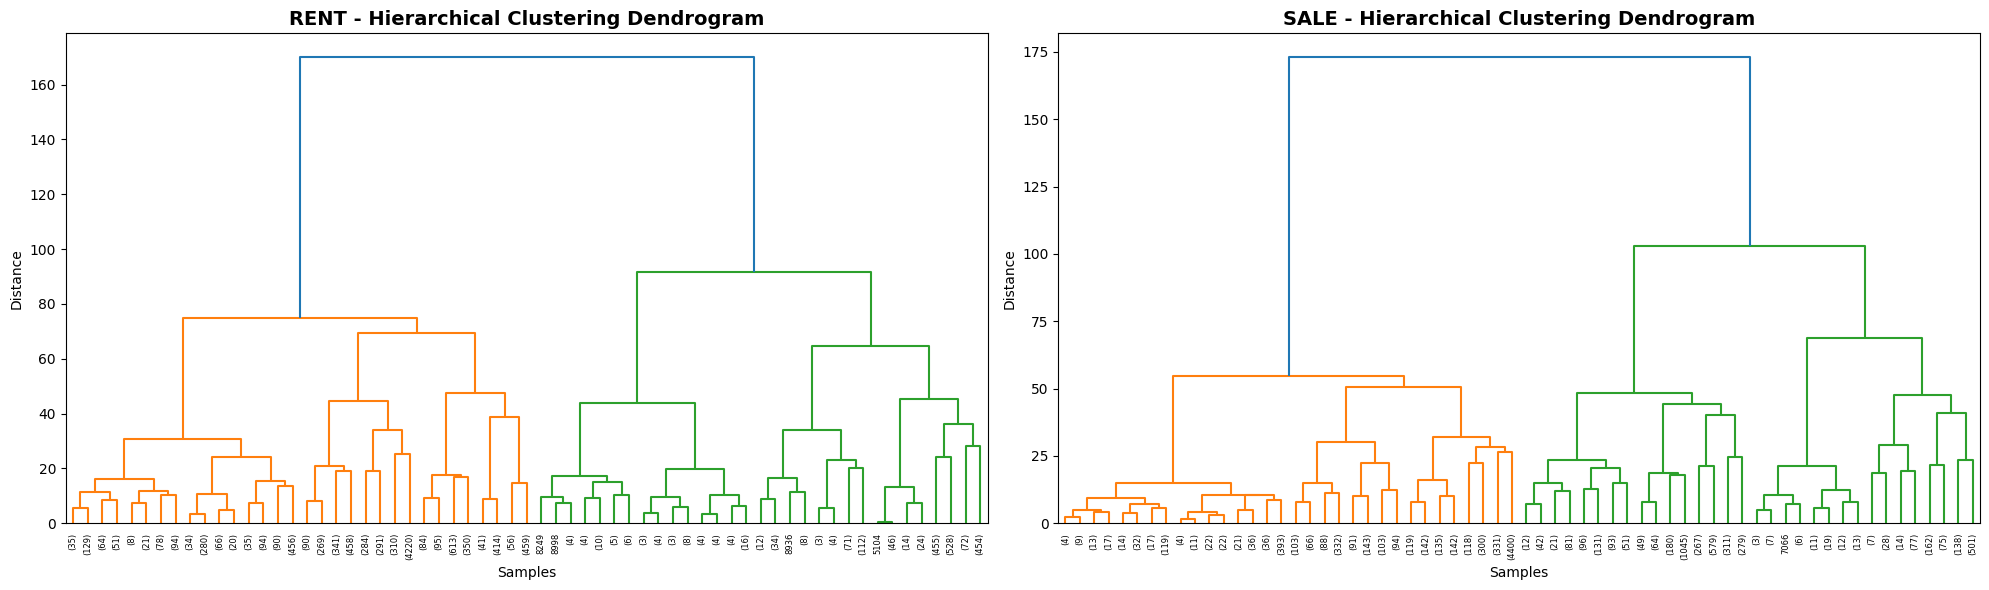

In [166]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Visualize dendrograms for both transaction types
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

if X_rent is not None and len(df_rent) > 0:
    Z_rent = linkage(X_rent, method="ward")
    axes[0].set_title("RENT - Hierarchical Clustering Dendrogram", fontsize=14, fontweight='bold')
    dendrogram(Z_rent, truncate_mode="level", p=5, ax=axes[0])
    axes[0].set_xlabel("Samples")
    axes[0].set_ylabel("Distance")
else:
    axes[0].text(0.5, 0.5, "No RENT data", ha='center', va='center', fontsize=14)
    axes[0].set_title("RENT - No data")

if X_sale is not None and len(df_sale) > 0:
    Z_sale = linkage(X_sale, method="ward")
    axes[1].set_title("SALE - Hierarchical Clustering Dendrogram", fontsize=14, fontweight='bold')
    dendrogram(Z_sale, truncate_mode="level", p=5, ax=axes[1])
    axes[1].set_xlabel("Samples")
    axes[1].set_ylabel("Distance")
else:
    axes[1].text(0.5, 0.5, "No SALE data", ha='center', va='center', fontsize=14)
    axes[1].set_title("SALE - No data")

plt.tight_layout()
plt.show()

In [167]:
from sklearn.cluster import AgglomerativeClustering

# Cluster RENT properties
if X_rent is not None and len(df_rent) > 0:
    n_clusters_rent = min(8, len(df_rent))  # Don't exceed number of samples
    clusterer_rent = AgglomerativeClustering(n_clusters=n_clusters_rent, linkage="ward")
    df_rent["cluster"] = clusterer_rent.fit_predict(X_rent)
    print(f"✓ RENT: Created {n_clusters_rent} clusters")
    print(df_rent["cluster"].value_counts().sort_index())
else:
    print("⚠️ Skipped RENT clustering")

print("\n" + "="*80 + "\n")

# Cluster SALE properties
if X_sale is not None and len(df_sale) > 0:
    n_clusters_sale = min(8, len(df_sale))  # Don't exceed number of samples
    clusterer_sale = AgglomerativeClustering(n_clusters=n_clusters_sale, linkage="ward")
    df_sale["cluster"] = clusterer_sale.fit_predict(X_sale)
    print(f"✓ SALE: Created {n_clusters_sale} clusters")
    print(df_sale["cluster"].value_counts().sort_index())
else:
    print("⚠️ Skipped SALE clustering")

✓ RENT: Created 8 clusters
cluster
0    6263
1     970
2      77
3    1555
4    1509
5     245
6    1142
7      85
Name: count, dtype: int64


✓ SALE: Created 8 clusters
cluster
0    2774
1     876
2    5687
3     126
4     770
5    1020
6     527
7      72
Name: count, dtype: int64


In [168]:
print_section("💰 IMPUTING MISSING PRICES")

# Function to impute prices with fallbacks
def impute_prices_with_fallbacks(df_trans, transaction_type):
    """Impute prices using cluster median, then property_type mean, then transaction mean"""
    
    if "cluster" not in df_trans.columns or len(df_trans) == 0:
        return df_trans
    
    # Step 1: Calculate cluster medians
    cluster_medians = df_trans.groupby("cluster")["price"].median()
    
    # Step 2: Calculate property_type means (for fallback)
    property_means = df_trans.groupby("property_type")["price"].mean()
    
    # Step 3: Calculate transaction-wide mean (final fallback)
    transaction_mean = df_trans["price"].mean()
    
    # Apply imputation
    missing_mask = df_trans["price"].isna()
    n_missing = missing_mask.sum()
    
    if n_missing == 0:
        print(f"  {transaction_type.upper()}: No missing prices")
        return df_trans
    
    print(f"  {transaction_type.upper()}: {n_missing} missing prices")
    
    # Level 1: Cluster median
    df_trans.loc[missing_mask, "price"] = df_trans.loc[missing_mask].apply(
        lambda row: cluster_medians.get(row["cluster"], np.nan), axis=1
    )
    
    still_missing = df_trans["price"].isna().sum()
    imputed_l1 = n_missing - still_missing
    print(f"    - Imputed {imputed_l1} using cluster median")
    
    # Level 2: Property type mean (if cluster median was NaN)
    if still_missing > 0:
        missing_mask = df_trans["price"].isna()
        df_trans.loc[missing_mask, "price"] = df_trans.loc[missing_mask].apply(
            lambda row: property_means.get(row["property_type"], np.nan), axis=1
        )
        
        still_missing_l2 = df_trans["price"].isna().sum()
        imputed_l2 = still_missing - still_missing_l2
        print(f"    - Imputed {imputed_l2} using property_type mean")
        still_missing = still_missing_l2
    
    # Level 3: Transaction mean (final fallback)
    if still_missing > 0:
        df_trans.loc[df_trans["price"].isna(), "price"] = transaction_mean
        imputed_l3 = still_missing
        print(f"    - Imputed {imputed_l3} using transaction mean ({transaction_mean:.0f})")
    
    return df_trans

# Impute RENT prices
if len(df_rent) > 0 and "cluster" in df_rent.columns:
    df_rent = impute_prices_with_fallbacks(df_rent, "rent")

# Impute SALE prices
if len(df_sale) > 0 and "cluster" in df_sale.columns:
    df_sale = impute_prices_with_fallbacks(df_sale, "sale")

# Combine back
df_clustered = pd.concat([df_rent, df_sale], ignore_index=False)

# Update df_clean with imputed prices
df_clean.loc[df_clustered.index, "price"] = df_clustered["price"]

# Handle rows that weren't in clustering (missing features)
# Use transaction + property_type group mean
missing_outside = df_clean["price"].isna()
n_missing_outside = missing_outside.sum()

if n_missing_outside > 0:
    print(f"\n  Rows outside clustering with missing price: {n_missing_outside}")
    
    # Try property_type + transaction mean
    group_means = df_clean.groupby(["transaction", "property_type"])["price"].transform("mean")
    df_clean.loc[missing_outside, "price"] = group_means[missing_outside]
    
    still_missing = df_clean["price"].isna().sum()
    imputed = n_missing_outside - still_missing
    print(f"    - Imputed {imputed} using transaction + property_type mean")
    
    # Final fallback: transaction mean
    if still_missing > 0:
        trans_means = df_clean.groupby("transaction")["price"].transform("mean")
        df_clean.loc[df_clean["price"].isna(), "price"] = trans_means[df_clean["price"].isna()]
        print(f"    - Imputed {still_missing} using transaction mean")

print(f"\n✓ Total missing prices after imputation: {df_clean['price'].isna().sum()}")

# Ensure amenity columns exist
amenity_columns = ['has_piscine', 'has_garage', 'has_jardin', 'has_terrasse', 'has_ascenseur', 'is_meuble', 'has_chauffage', 'has_climatisation']
for col in amenity_columns:
    if col not in df_clean.columns:
        df_clean[col] = False


💰 IMPUTING MISSING PRICES
  RENT: 5517 missing prices
    - Imputed 5517 using cluster median
  SALE: 3007 missing prices
    - Imputed 3007 using cluster median

✓ Total missing prices after imputation: 0


In [169]:
final_columns = [
    "price","transaction","region",  # Removed city - only using region
    "surface","bathrooms","rooms","property_type",
    "has_piscine","has_garage","has_jardin","has_terrasse","has_ascenseur","is_meuble",
    "has_chauffage","has_climatisation"
]

df_clean = df_clean[final_columns]

## 11) Final Summary

In [170]:
print_section("📊 FINAL DATASET SUMMARY")

print(f"Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns\n")

print("Columns:")
for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    nulls = df_clean[col].isna().sum()
    null_pct = (nulls / len(df_clean)) * 100
    print(f"  {i:2d}. {col:20s} | {str(dtype):15s} | {nulls:,} nulls ({null_pct:.1f}%)")

print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print("\nProperty Type Distribution:")
print(df_clean['property_type'].value_counts())

print("\nTransaction Distribution:")
print(df_clean['transaction'].value_counts(dropna=False))

print("\nTop 10 Regions:")
print(df_clean['region'].value_counts().head(10))

analyze_missing_values(df_clean, "Final Dataset")


📊 FINAL DATASET SUMMARY
Shape: 23,698 rows × 15 columns

Columns:
   1. price                | float64         | 0 nulls (0.0%)
   2. transaction          | category        | 0 nulls (0.0%)
   3. region               | category        | 0 nulls (0.0%)
   4. surface              | float64         | 0 nulls (0.0%)
   5. bathrooms            | Int64           | 0 nulls (0.0%)
   6. rooms                | Int64           | 0 nulls (0.0%)
   7. property_type        | category        | 0 nulls (0.0%)
   8. has_piscine          | bool            | 0 nulls (0.0%)
   9. has_garage           | bool            | 0 nulls (0.0%)
  10. has_jardin           | bool            | 0 nulls (0.0%)
  11. has_terrasse         | bool            | 0 nulls (0.0%)
  12. has_ascenseur        | bool            | 0 nulls (0.0%)
  13. is_meuble            | bool            | 0 nulls (0.0%)
  14. has_chauffage        | bool            | 0 nulls (0.0%)
  15. has_climatisation    | bool            | 0 nulls (0.0%)

KE

,Column,Missing,Percent


In [171]:
print("\n=== FINAL CLEANED DATASET (First 10 rows) ===")
display(df_clean.head(10))


=== FINAL CLEANED DATASET (First 10 rows) ===


,price,transaction,region,surface,bathrooms,rooms,property_type,has_piscine,has_garage,has_jardin,has_terrasse,has_ascenseur,is_meuble,has_chauffage,has_climatisation
0,6800.0,rent,La Marsa,350.000000,1,4,Appartement,False,False,False,True,False,False,True,True
1,5850.0,rent,Carthage,83.250000,3,3,Villa,True,False,True,False,True,False,False,True
2,1500.0,rent,La Marsa,152.117647,2,2,Appartement,False,True,False,False,False,False,False,False
3,5850.0,rent,La Marsa,81.714286,3,2,Villa,True,True,True,True,False,False,False,False
4,2550.0,rent,La Marsa,145.000000,2,2,Appartement,False,True,False,True,True,False,False,False
5,1150.0,rent,La Soukra,44.000000,1,1,Appartement,False,True,False,False,False,False,False,False
6,4900.0,rent,La Marsa,260.000000,3,3,Appartement,False,True,True,False,False,True,False,False
8,1400.0,rent,La Marsa,120.000000,1,3,Appartement,False,False,True,True,False,False,False,False
9,750.0,rent,Boumhel Bassatine,64.000000,1,1,Appartement,False,True,False,True,True,False,False,False
10,5850.0,rent,La Marsa,81.714286,3,2,Villa,True,True,True,False,False,True,False,False


In [172]:
# Save cleaned dataset to CSV
output_path = r"C:\Users\user\OneDrive\Bureau\Data Mining Projecy\Tunisan-Real-Estate-Price-Prediction-Platform\ML\data\processed\cleaned_real_estate.csv"
df_clean.to_csv(output_path, index=False)
print(f"\n✓ Cleaned dataset saved to: {output_path}")
print(f"Total rows saved: {len(df_clean)}")
print(f"Total columns saved: {len(df_clean.columns)}")


✓ Cleaned dataset saved to: C:\Users\user\OneDrive\Bureau\Data Mining Projecy\Tunisan-Real-Estate-Price-Prediction-Platform\ML\data\processed\cleaned_real_estate.csv
Total rows saved: 23698
Total columns saved: 15


In [173]:
# Price Range Analysis per Transaction Type (AFTER CLUSTERING)
print("\n" + "="*80)
print("PRICE RANGE ANALYSIS BY TRANSACTION TYPE (AFTER CLUSTERING)")
print("="*80 + "\n")

for transaction_type in df_clean['transaction'].unique():
    if pd.notna(transaction_type):
        trans_data = df_clean[df_clean['transaction'] == transaction_type]['price']
        print(f"\n{transaction_type.upper()}:")
        print(f"  Count: {len(trans_data):,}")
        print(f"  Min: {trans_data.min():,.0f} TND")
        print(f"  Max: {trans_data.max():,.0f} TND")
        print(f"  Mean: {trans_data.mean():,.0f} TND")
        print(f"  Median: {trans_data.median():,.0f} TND")
        print(f"  Std Dev: {trans_data.std():,.0f} TND")
        print(f"  25th percentile: {trans_data.quantile(0.25):,.0f} TND")
        print(f"  75th percentile: {trans_data.quantile(0.75):,.0f} TND")


PRICE RANGE ANALYSIS BY TRANSACTION TYPE (AFTER CLUSTERING)


RENT:
  Count: 11,846
  Min: 300 TND
  Max: 20,000 TND
  Mean: 2,867 TND
  Median: 1,600 TND
  Std Dev: 2,873 TND
  25th percentile: 1,500 TND
  75th percentile: 3,000 TND

SALE:
  Count: 11,852
  Min: 50,000 TND
  Max: 5,000,000 TND
  Mean: 639,440 TND
  Median: 435,000 TND
  Std Dev: 547,282 TND
  25th percentile: 300,000 TND
  75th percentile: 750,000 TND
